In [20]:
import os
import numpy as np
import pandas as pd
import importlib
from psifr import fr
from cfr import framework
from cymr import network

model_dir = '/Users/morton/Dropbox/work/cmr_cfr/cfr'
data_file = os.path.join(model_dir, 'cfr_eeg_mixed.csv')
patterns_file = os.path.join(model_dir, 'cfr_patterns.hdf5')
fit_dir = os.path.join(model_dir, 'fits', 'v3')
fig_dir = '/Users/morton/manuscripts/cfr/figs/cfr'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

## Load model fits

In [6]:
components = ['loc', 'cat', 'use', 'loc-cat', 'loc-use', 'cat-use', 'loc-cat-use']
base_models = [f'cmr_fcf-{comp}' for comp in components]
base_names = ['I', 'C', 'S', 'IC', 'IS', 'CS', 'ICS']

new_models = ['cmr_fcf-loc-cat_ff-use', 'cmr_fcf-loc_ff-cat-use',
              'cmr_fcf-loc-cat-use_ff-use', 'cmr_fcf-loc-cat_ff-cat-use', 'cmr_fcf-loc-cat-use_ff-cat-use']
new_names = ['IC-S', 'I-CS', 'ICS-S', 'IC-CS', 'ICS-CS']
models = base_models + new_models
model_names = base_names + new_names
res = framework.read_model_fits(fit_dir, models, model_names)
res

rep  Afc  Acf  Aff       Dff    T     w_loc       Lfc  \
model  subject                                                          
I      1          2  0.0  0.0  0.0  1.000000  0.1  1.000000  0.188871   
       2          1  0.0  0.0  0.0  1.000000  0.1  1.000000  0.139566   
       3          1  0.0  0.0  0.0  1.000000  0.1  1.000000  0.084998   
       5          0  0.0  0.0  0.0  1.000000  0.1  1.000000  0.175249   
       8          2  0.0  0.0  0.0  1.000000  0.1  1.000000  0.115344   
...             ...  ...  ...  ...       ...  ...       ...       ...   
ICS-CS 42         2  0.0  0.0  0.0  0.171816  0.1  0.999088  0.044139   
       43         2  0.0  0.0  0.0  0.167173  0.1  0.999084  0.058051   
       44         0  0.0  0.0  0.0  0.077639  0.1  1.000000  0.028334   
       45         2  0.0  0.0  0.0  0.073472  0.1  0.998491  0.018541   
       46         0  0.0  0.0  0.0  0.094752  0.1  1.000000  0.114735   

                         Lcf        P1  ...         logl      n     k  \
model  subject                          ...                             
I      1        8.850760e-02  0.186258  ...  -899.540087  373.0   9.0   
       2        1.320660e-01  0.294150  ... -1014.021228  426.0   9.0   
       3        6.130060e-02  0.941383  ...  -927.932940  379.0   9.0   
       5        1.635574e-01  0.080227  ... -1218.473199  517.0   9.0   
       8        3.204213e-02  0.086330  ...  -784.548449  320.0   9.0   
...                      ...       ...  ...          ...    ...   ...   
ICS-CS 42       2.639631e-02  0.062763  ...  -732.302989  311.0  13.0   
       43       0.000000e+00  0.104089  ... -1009.202631  428.0  13.0   
       44       1.312626e-08  0.209935  ...  -854.673170  352.0  13.0   
       45       0.000000e+00  0.000000  ...  -892.286580  374.0  13.0   
       46       7.732212e-02  0.162094  ...  -978.741593  430.0  13.0   

                   w_cat     w_use        w0        w1     s_use        s0  \
model  subject                                                               
I      1             NaN       NaN       NaN       NaN       NaN       NaN   
       2             NaN       NaN       NaN       NaN       NaN       NaN   
       3             NaN       NaN       NaN       NaN       NaN       NaN   
       5             NaN       NaN       NaN       NaN       NaN       NaN   
       8             NaN       NaN       NaN       NaN       NaN       NaN   
...                  ...       ...       ...       ...       ...       ...   
ICS-CS 42       0.000912  0.004157  0.999088  0.004157  0.931449  0.068551   
       43       0.000916  0.002268  0.999084  0.002268  0.647951  0.352049   
       44       0.000000  0.000374  1.000000  0.000374  0.490738  0.509262   
       45       0.001509  0.001785  0.998491  0.001785  0.226935  0.773065   
       46       0.000000  0.001040  1.000000  0.001040  0.455527  0.544473   

                   s_cat  
model  subject            
I      1             NaN  
       2             NaN  
       3             NaN  
       5             NaN  
       8             NaN  
...                  ...  
ICS-CS 42       0.068551  
       43       0.352049  
       44       0.509262  
       45       0.773065  
       46       0.544473  

[348 rows x 28 columns]

In [26]:
res.groupby('model')['logl'].sum().sort_values()

model
S        -29455.676076
C        -28324.622510
CS       -28199.304091
I        -27395.002983
IS       -26663.291611
IC       -26275.368792
ICS      -26149.719174
ICS-S    -25981.282112
IC-S     -25979.989042
ICS-CS   -25627.074757
I-CS     -25626.934452
IC-CS    -25626.933197
Name: logl, dtype: float64

## Calculate AIC weights

In [7]:
res['aic'] = framework.aic(res['logl'], res['n'], res['k'])
aic = res.reset_index().pivot(index='subject', columns='model', values='aic')
aic = aic.reindex(columns=model_names)
waic = aic.copy()
waic.iloc[:, :] = framework.waic(aic.to_numpy())

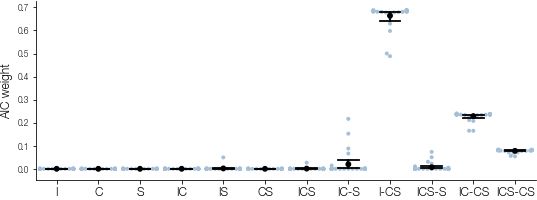

In [11]:
c = [.65, .75, .85]
df = waic.reset_index().melt(id_vars='subject', value_name='waic')
g = fr.plot_swarm_error(df, x='model', y='waic', height=3, aspect=2.5,
                        swarm_color=c, swarm_size=4)
g.set(ylabel='AIC weight');
g.axes[0, 0].tick_params(axis='x', labelsize='large')
#g.savefig(os.path.join(fig_dir, 'waic.pdf'))

In [12]:
data = framework.read_model_sims(data_file, fit_dir, models, model_names)

## Clustering for all models

In [13]:
lag_rank_within = data.groupby('source').apply(
    fr.lag_rank, test_key='category', test=lambda x, y: x == y
)

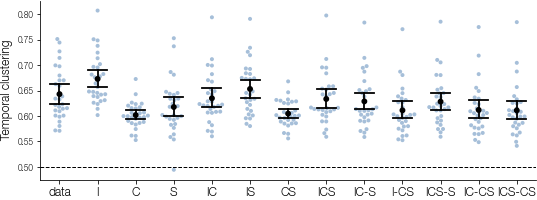

In [14]:
c = [.65, .75, .85]
g = fr.plot_swarm_error(lag_rank_within, x='source', y='rank', swarm_size=4,
                        height=3, aspect=2.5, swarm_color=c)
g.axes[0, 0].plot(g.axes[0, 0].get_xlim(), [.5, .5], '--k');
g.set(ylabel='Temporal clustering');
g.axes[0, 0].tick_params(axis='x', labelsize='large');
#g.savefig(os.path.join(fig_dir, 'comp_lag_rank.pdf'))

In [15]:
cat_crp = data.groupby('source').apply(
    fr.category_crp, category_key='category'
)

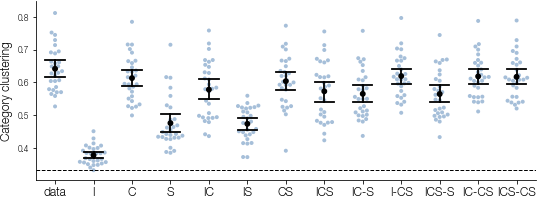

In [18]:
import importlib
import seaborn as sns
importlib.reload(sns)
importlib.reload(fr)
g = fr.plot_swarm_error(cat_crp, x='source', y='prob', swarm_size=4,
                        height=3, aspect=2.5, swarm_color=c)
g.axes[0, 0].plot(g.axes[0, 0].get_xlim(), [1/3, 1/3], '--k');
g.set(ylabel='Category clustering');
g.axes[0, 0].tick_params(axis='x', labelsize='large');
#g.savefig(os.path.join(fig_dir, 'comp_cat_crp.pdf'))

In [21]:
patterns = network.load_patterns(patterns_file)
rsm = patterns['similarity']['use']

In [22]:
use_rank = data.groupby('source').apply(
    fr.distance_rank, 'item_index', 1 - rsm, test_key='category',
    test=lambda x, y: x == y
)

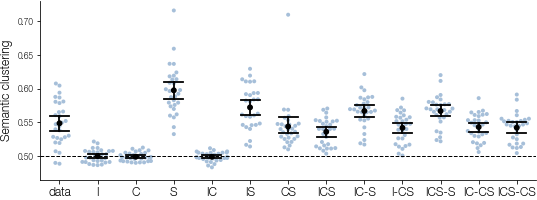

In [24]:
g = fr.plot_swarm_error(use_rank, x='source', y='rank', swarm_size=4,
                        height=3, aspect=2.5, swarm_color=c)
g.axes[0, 0].plot(g.axes[0, 0].get_xlim(), [.5, .5], '--k');
g.set(ylabel='Semantic clustering');
g.axes[0, 0].tick_params(axis='x', labelsize='large');
#g.savefig(os.path.join(fig_dir, 'comp_use_rank.pdf'))